In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import scipy.stats as sps

from collections import OrderedDict

In [2]:
import elfi

In [3]:
from abc_reconstruction.model import Model
from abc_reconstruction.utils import PriorPosition  #, cart_to_pol, pol_to_cart
from abc_reconstruction.prior import BoundedNormal_x, BoundedNormal_y

You don't have ROOT or root_pandas, root truth file output is disabled


# Init model

In [4]:
model = Model('XENON1T_ABC.ini')  #, coordinate_system = 'polar')

In [5]:
min_model = Model('XENON1T_ABC_minimal.ini')

In [6]:
model.change_defaults(s2_electrons = 25)
min_model.change_defaults(s2_electrons = 25)

In [7]:
prior_mean = PriorPosition()

In [8]:
true_pos = np.loadtxt('data/truepos')

In [9]:
# Profiling test
#import cProfile

In [10]:
#cProfile.run('min_model(0,0)')  #, filename='profile_min_model00.cprof', sort='cumtime')

In [11]:
#%timeit -n 20 model(0,0)

In [12]:
#%timeit -n 20 min_model(0,0)

In [13]:
model(0, 0, 0, 15)

array([ 1.02598811,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.15403629,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.58237605,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.63626477,  0.        ,  0.70874742,  0.61453148,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.46684949,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.07022308,  0.        ,
        0.        ,  1.18925025,  2.48690086,  0.        ,  0.        ,
        0.        ,  1.76976663,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

# Select pattern to reconstruct

In [14]:
# The true position of the hitpattern
#truth = np.array([0, 47.9])
truth = true_pos[0]
print(truth)

[  2.62643434 -17.96082368]


In [15]:
true_z = -20
true_e = 25

In [16]:
#cart_to_pol(*true_pos[0])

In [17]:
# The hitpattern to reconstruct
#data = model(*cart_to_pol(*true_pos[0]))
data = model(*truth,true_z, true_e)
# What pax thinks of this hitpattern
pax_pos = model.get_latest_pax_position()
# The prior mean (not used)
prior_pos = prior_mean(data) 

In [18]:
pax_pos

{'PosRecNeuralNet': {'x': 3.1306333903189207, 'y': -17.262859490781327},
 'PosRecTopPatternFit': {'x': 1.8703007518796966, 'y': -17.082080200501252}}

In [19]:
prior_pos

(4.115222817130077, -15.358220637996187)

In [20]:
#prior_pos_pol = cart_to_pol(*prior_pos)

# Build ELFI Priors

In [21]:
r_bound = 47.8  # 1 mm less then TPF bound because of bug in 

In [22]:
prior_pos

(4.115222817130077, -15.358220637996187)

In [23]:
# Custom Poisson Prior with 'pdf' method as workaround
#import elfi.Distribution

class PoissonPrior(elfi.Distribution):
    def rvs(mu, loc=0, size=1, random_state=None):
        return sps.poisson.rvs(mu=mu, loc=loc, size=size, random_state=random_state)
    
    def pdf(k, mu, loc=0):  # ELFI needs a 'pdf' function instead of pmf
        return sps.poisson.pmf(k=k, mu=mu, loc=loc)

In [24]:
px = elfi.Prior(BoundedNormal_x, r_bound, prior_pos, 64)
py = elfi.Prior(BoundedNormal_y, px, r_bound, prior_pos, 64)
pz = elfi.Prior('truncnorm', -96, 0, -20, 3)
pe = elfi.Prior('truncnorm', 0, 100, 25, 3)  # Needs to be discrete distribution! Built workaround for now

## Get PMT mask

In [25]:
pmt_mask = model.pmt_mask[:127].astype(int)

In [26]:
pmt_mask

array([1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1])

# Build BOLFI Model

In [27]:
min_model=elfi.tools.vectorize(min_model)

In [28]:
Y = elfi.Simulator(min_model, px, py, pz, pe, observed=data)

In [29]:
# Test calling FM
#elfi.Simulator.generate(Y)

## Define Distance functions

In [30]:
d = elfi.Distance('braycurtis', Y, w=pmt_mask)
log_d = elfi.Operation(np.log, d)

# Distance cannot take weigths kwarg when passing callable instead of string, using functools instead
#log_d = elfi.Distance(likelihood_chisquare_masked, Y)

In [31]:
# Check Summary stat
#elfi.Simulator.generate(d)
#elfi.Simulator.generate(log_d)

In [32]:
# Load modified minimize function which we can pass different minimizer method and constraint.
from abc_reconstruction.utils import minimize, ConstraintLCBSC

In [33]:
from elfi.methods.bo.gpy_regression import GPyRegression
from elfi.methods.utils import ModelPrior

In [34]:
bounds = {'px':(-r_bound, r_bound),
          'py':(-r_bound, r_bound),
          'pz':(-96, 0),
          'pe':(0, 100),
         } 

In [35]:
# To fix in ELFI, using discrete distributions in ModelPrior -> elfi.model.augmenter._add_distribution_nodes()
# For now workaround by using custom Prior

In [36]:
log_d.model.parameter_names

['pe', 'px', 'py', 'pz']

In [37]:
# Define the default GP target model
target_model = GPyRegression(log_d.model.parameter_names, bounds=bounds)

# Define the custom acquisition method
acquisition_method = ConstraintLCBSC(target_model,
                                     prior = ModelPrior(log_d.model),
                                     noise_var = 0.1,  # [0.1, 0.1],
                                     exploration_rate = 10,
                                     #seed=self.seed  # Use np.random
                                    )
acquisition_method.d0 = 1  # Workaround for now, order of parameter_names is not always the same, set d0 and d1 to the x and y dimension (here 1 and 2)
acquisition_method.d1 = 2

In [38]:
target_model.bounds

[(0, 100), (-47.8, 47.8), (-47.8, 47.8), (-96, 0)]

In [39]:
bolfi = elfi.BOLFI(log_d, batch_size=1, initial_evidence=20, update_interval=1,
                   #bounds=bounds,  # Not used when using target_model
                   target_model = target_model,
                   acquisition_method = acquisition_method,
                   #acq_noise_var=[0.1, 0.1],  # Not used when using acquisition_method
                   #async=True,  # Could we use this?
                  )

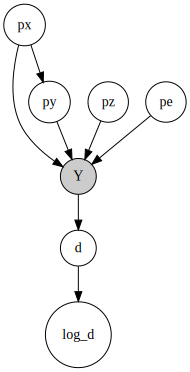

In [40]:
elfi.draw(px)

# Fit GP model

In [41]:
%time post = bolfi.fit(n_evidence=200)

CPU times: user 14min 30s, sys: 21min 19s, total: 35min 50s
Wall time: 5min 22s


In [42]:
# Test animation
#for b in range(1, 200):
#bolfi.set_objective(n_evidence=200)  # b
#bolfi.iterate()  # Calls update()
#bolfi.plot_state()
#    plt.savefig('bolfi_surface_%03d.png' % b, dpi=150)
#bolfi.infer(n_evidence=100, vis=dict(xlim=(-r_bound, r_bound), ylim=(-r_bound, r_bound)))

In [43]:
bolfi.target_model


Name : GP regression
Objective : -4.591128812340074
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |     priors    
  sum.rbf.variance         |    0.04236410310302742  |      +ve      |  Ga(0.022, 1) 
  sum.rbf.lengthscale      |      32.24632525076998  |      +ve      |    Ga(65, 1)  
  sum.bias.variance        |  6.729772049584947e-05  |      +ve      |  Ga(0.0055, 1)
  Gaussian_noise.variance  |    0.02653218682755095  |      +ve      |               

In [44]:
def plot(dim_0 = 0, dim_1 = 1):
    samples = bolfi.target_model.X
    bounds = bolfi.target_model.bounds
    names = log_d.model.parameter_names

    plt.scatter(samples[:,dim_0], samples[:,dim_1])
    plt.xlim(bounds[dim_0])
    plt.ylim(bounds[dim_1])
    plt.xlabel(names[dim_0])
    plt.ylabel(names[dim_1])

In [45]:
bolfi.target_model.X.shape

(200, 4)

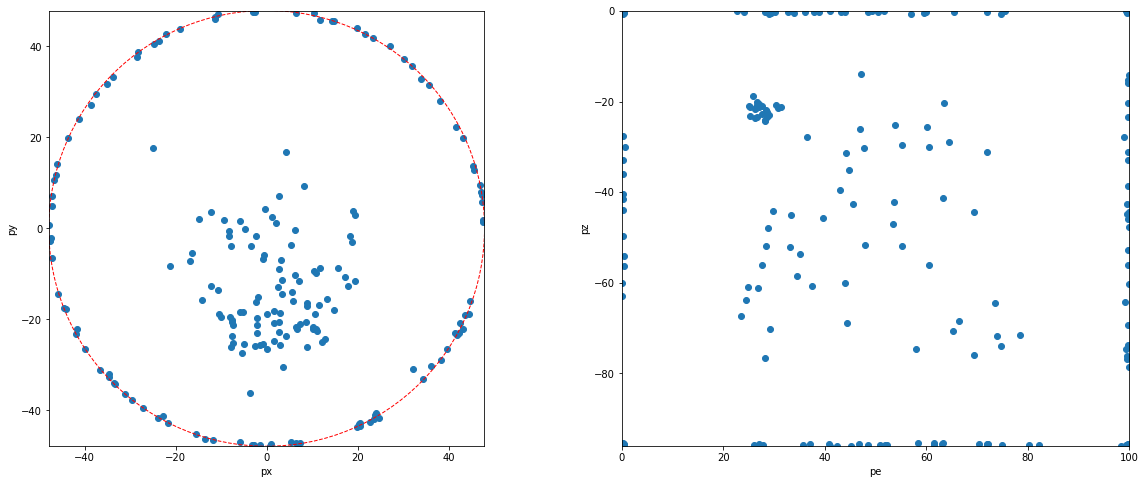

In [46]:
#plot(0, 1)  # e,x
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plot(1, 2)  # x,y
plt.gca().set_aspect(1)
plt.gca().add_artist(plt.Circle((0,0), 47.9, color='red', fill=False, linestyle='--'))

plt.subplot(1, 2, 2)
#plot(2, 3)  # y,z
plot(0, 3)
#plt.gca().add_artist(plt.Circle((0,0), 47.9, color='red', fill=False, linestyle='--'))
plt.show()

In [47]:
#bolfi.plot_state()
#plt.xlim(-50, 50)
#plt.ylim(-50, 50)
#for ax in plt.gcf().axes:
#    ax.add_artist(plt.Circle((0,0), 47.9, color='red', fill=False, linestyle='--'))
#plt.savefig('surface_constraint_edge_noise.png', dpi=150)
#plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f76da198ba8>,
      dtype=object)

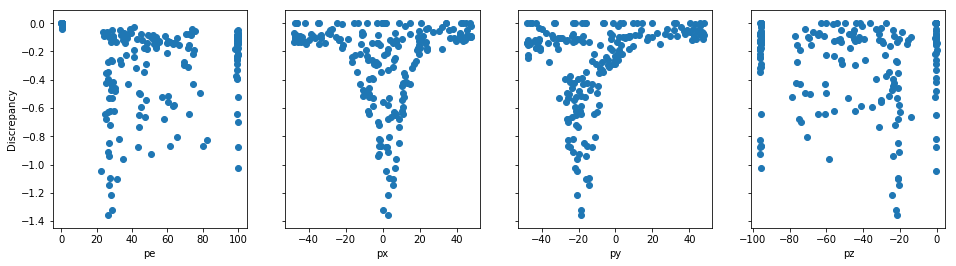

In [48]:
bolfi.plot_discrepancy()
#plt.savefig('test_xyze.png', dpi=150)

In [50]:
#post.plot(logpdf=True)  # Only for 2D

# Sample from GP model

In [51]:
#bolfi.sample?

In [52]:
#%time result_BOLFI = bolfi.sample(500, warmup=100, n_chains=8, info_freq=500)  # 500/100 23s, 1000/500 4 45s, 
%time result_BOLFI = bolfi.sample(1000, info_freq=1000)  

4 chains of 1000 iterations acquired. Effective sample size and Rhat for each parameter:
pe 281.6019564661462 1.0142112816981224
px 75.16587632457254 1.0558686255858287
py 44.77099406768514 1.0477577971562404
pz 295.5587443159474 1.0177226575865972
CPU times: user 16min 51s, sys: 13min 53s, total: 30min 45s
Wall time: 7min 41s


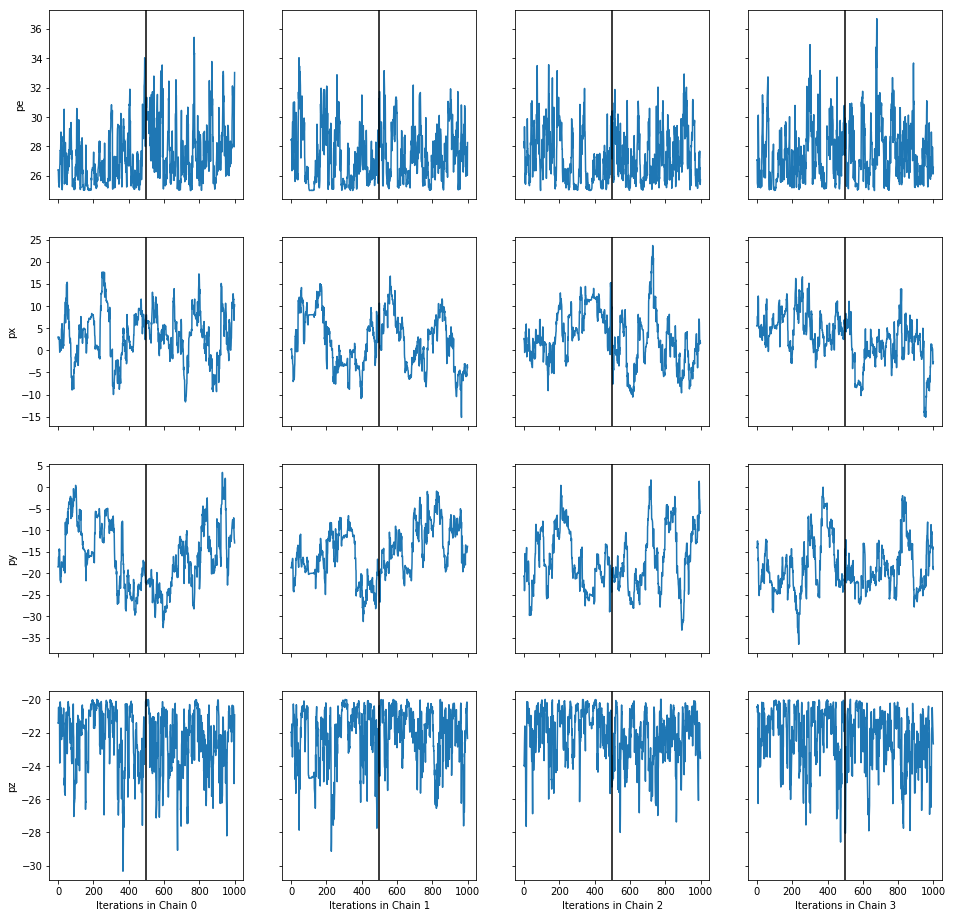

In [53]:
result_BOLFI.plot_traces();

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f76d9a042e8>,
      dtype=object)

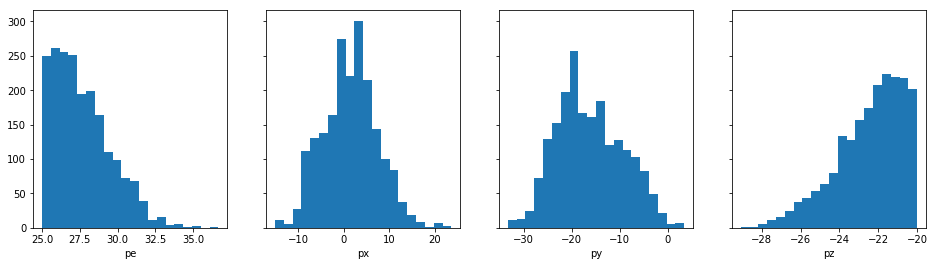

In [54]:
result_BOLFI.plot_marginals()

In [55]:
print('mean e: %.2f electrons,\t true e: %d' % (result_BOLFI.sample_means['pe'], true_e))
print('mean z: %.2f cm,\t\t true z: %.2f' % (result_BOLFI.sample_means['pz'], true_z))

mean e: 27.65 electrons,	 true e: 25
mean z: -22.44 cm,		 true z: -20.00


In [56]:
res = OrderedDict()
res['mean'] = [result_BOLFI.sample_means['px'], result_BOLFI.sample_means['py']]
res['median'] = bolfi_median = np.median(result_BOLFI.samples_array, axis=0)
res['mode'] = sps.mode(result_BOLFI.samples_array).mode[0]
res['truth'] = truth
res['tpf'] = [pax_pos['PosRecTopPatternFit']['x'], pax_pos['PosRecTopPatternFit']['y']]
res['nn'] = [pax_pos['PosRecNeuralNet']['x'], pax_pos['PosRecNeuralNet']['y']]

for k, v in res.items():
    if k == 'truth':
        print('%s:\t x=%.2f cm,\t y=%.2f cm' % (k, v[0], v[1]))
    else:
        d = ((truth[0] - v[0])**2 + (truth[1] -  v[1])**2)**0.5
        print('%s:\t x=%.2f cm,\t y=%.2f cm,\t d_truth=%.2f cm' % (k, v[0], v[1], d))


mean:	 x=1.48 cm,	 y=-16.28 cm,	 d_truth=2.03 cm
median:	 x=27.28 cm,	 y=1.57 cm,	 d_truth=31.45 cm
mode:	 x=27.02 cm,	 y=7.11 cm,	 d_truth=34.97 cm
truth:	 x=2.63 cm,	 y=-17.96 cm
tpf:	 x=1.87 cm,	 y=-17.08 cm,	 d_truth=1.16 cm
nn:	 x=3.13 cm,	 y=-17.26 cm,	 d_truth=0.86 cm
